# Stock Keeping Unit Forecasting 
# All Zones

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import mlflow
import mlflow.sklearn
print("Using mlflow version {}".format(mlflow.__version__))

Using mlflow version 1.24.0


In [68]:
%run ./data_loader

### Data Collection

In [69]:
load_data = Data_Reader()

In [70]:
data = load_data.get_data()

In [71]:
df_global = data['global']

In [72]:
df_global

,Zone,Country_Code,Material_Code,Date,Demand
0,1,1,1,2018-01-06,32160
1,1,1,2,2018-01-06,93840
2,1,1,3,2018-01-06,78000
3,1,1,4,2018-01-06,0
4,1,1,5,2018-01-06,63600
...,...,...,...,...,...
598879,4,42,684,2021-12-25,0
598880,4,42,685,2021-12-25,0
598881,4,42,651,2021-12-25,0
598882,4,42,62,2021-12-25,0


Client forecast data import for further comparison

In [73]:
forecast_load_data = Forecast_Data_Reader()

In [74]:
forecast_data = forecast_load_data.read_file()
forecast_data

,Date,Demand,week,month,year
SKU,,,,,
country_1_material_1,2020-11-14,18240,46,11,2020
country_1_material_2,2020-11-14,51120,46,11,2020
country_1_material_3,2020-11-14,0,46,11,2020
country_1_material_4,2020-11-14,0,46,11,2020
country_1_material_5,2020-11-14,0,46,11,2020
...,...,...,...,...,...
country_42_material_59,2021-12-25,57900,51,12,2021
country_42_material_60,2021-12-25,202260,51,12,2021
country_42_material_61,2021-12-25,156840,51,12,2021


### Data Analysis

In [75]:
df_global_clean = df_global.copy()

In [76]:
df_global_clean['SKU'] = "country_" + df_global_clean["Country_Code"].astype(str) + "_material_" +  df_global_clean["Material_Code"].astype(str)
df_global['SKU'] = df_global_clean['SKU']
skus_list = df_global_clean['SKU'].unique()

In [77]:
df_global_clean = df_global_clean.set_index('SKU')

Negative values: The approch used for negative values will be to replace them by zero values

In [78]:
df_global_clean[df_global_clean['Demand'] < 0]

,Zone,Country_Code,Material_Code,Date,Demand
SKU,,,,,
country_1_material_4,1,1,4,2018-07-21,-2880
country_1_material_37,1,1,37,2018-07-21,-2160
country_1_material_6,1,1,6,2019-07-20,-1200
country_1_material_194,1,1,194,2019-11-30,-240
country_1_material_194,1,1,194,2020-01-25,-1680
...,...,...,...,...,...
country_26_material_111,2,26,111,2021-12-18,-1440
country_38_material_300,2,38,300,2021-12-18,-4560
country_38_material_303,2,38,303,2021-12-18,-1440


In [79]:
df_global_clean.loc[(df_global_clean['Demand'] < 0), 'Demand'] = 0

Build a SKUs description table

In [80]:
df_skus_overview = pd.DataFrame()
df_calc = df_global_clean.drop(columns=['Material_Code', 'Zone', 'Country_Code', 'Date'])

df_skus_overview['sum'] = df_calc.groupby(['SKU']).sum()
df_skus_overview['mean'] = df_calc.groupby(['SKU']).mean()
df_skus_overview['median'] = df_calc.groupby(['SKU']).median()
df_skus_overview['std'] = df_calc.groupby(['SKU']).std()
df_skus_overview['skewness'] = df_calc.groupby(['SKU']).skew()
df_skus_overview['kurtosis'] = df_calc.groupby(['SKU']).apply(pd.DataFrame.kurt)
df_skus_overview['coef_var'] = df_skus_overview['mean']/df_skus_overview['std']
df_skus_overview['coef_var'] = df_skus_overview['coef_var'].fillna(0)
df_skus_overview['data_size'] = df_calc.groupby(['SKU']).count()

df_skus_overview

,sum,mean,median,std,skewness,kurtosis,coef_var,data_size
SKU,,,,,,,,
country_10_material_1,1097760,5277.692308,5040.0,1436.515666,0.813211,1.390372,3.673954,208
country_10_material_10,382560,1839.230769,1200.0,3079.760230,3.410205,14.458613,0.597199,208
country_10_material_11,576960,2773.846154,3000.0,3065.672273,2.196293,10.346101,0.904808,208
country_10_material_13,1298400,6242.307692,0.0,8532.111918,0.808925,-1.034731,0.731625,208
country_10_material_14,1097040,5274.230769,0.0,7350.710202,0.863697,-0.902615,0.717513,208
...,...,...,...,...,...,...,...,...
country_9_material_616,0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,59
country_9_material_619,82560,1399.322034,0.0,3783.765623,2.912365,8.387112,0.369823,59
country_9_material_622,960,16.271186,0.0,98.294040,6.754958,47.589518,0.165536,59


In [81]:
df_dates = pd.DataFrame(columns=["SKU", "min_date", "max_date"])
for sku in skus_list:
    r = df_global_clean.loc[[sku]]
    vals_date = pd.DataFrame([{'SKU': sku, 'min_date': r['Date'].min(), 'max_date': r['Date'].max()}])    
    df_dates = df_dates.append(vals_date, ignore_index=True)

In [82]:
df_dates

,SKU,min_date,max_date
0,country_1_material_1,2018-01-06,2021-12-25
1,country_1_material_2,2018-01-06,2021-12-25
2,country_1_material_3,2018-01-06,2021-12-25
3,country_1_material_4,2018-01-06,2020-11-07
4,country_1_material_5,2018-01-06,2020-11-07
...,...,...,...
4540,country_42_material_758,2020-11-14,2021-12-25
4541,country_42_material_636,2020-11-14,2021-12-25
4542,country_42_material_684,2020-11-14,2021-12-25
4543,country_42_material_685,2020-11-14,2021-12-25


In [83]:
df_skus_overview = df_skus_overview.merge(df_dates, on='SKU')
df_skus_overview = df_skus_overview.set_index('SKU')

In [84]:
df_skus_overview

,sum,mean,median,std,skewness,kurtosis,coef_var,data_size,min_date,max_date
SKU,,,,,,,,,,
country_10_material_1,1097760,5277.692308,5040.0,1436.515666,0.813211,1.390372,3.673954,208,2018-01-06,2021-12-25
country_10_material_10,382560,1839.230769,1200.0,3079.760230,3.410205,14.458613,0.597199,208,2018-01-06,2021-12-25
country_10_material_11,576960,2773.846154,3000.0,3065.672273,2.196293,10.346101,0.904808,208,2018-01-06,2021-12-25
country_10_material_13,1298400,6242.307692,0.0,8532.111918,0.808925,-1.034731,0.731625,208,2018-01-06,2021-12-25
country_10_material_14,1097040,5274.230769,0.0,7350.710202,0.863697,-0.902615,0.717513,208,2018-01-06,2021-12-25
...,...,...,...,...,...,...,...,...,...,...
country_9_material_616,0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,59,2020-11-14,2021-12-25
country_9_material_619,82560,1399.322034,0.0,3783.765623,2.912365,8.387112,0.369823,59,2020-11-14,2021-12-25
country_9_material_622,960,16.271186,0.0,98.294040,6.754958,47.589518,0.165536,59,2020-11-14,2021-12-25


Calculate zero percentage for each SKU

In [85]:
def zero_classify(percentage):
    if percentage >= 0 and percentage < 0.25:
        classification = '0_25'
    elif percentage >= 0.25 and percentage < 0.50:
        classification = '25_50'
    elif percentage >= 0.50 and percentage < 0.75:
        classification = '50_75'
    else:
        classification = '75_100'
    return classification        

In [86]:
# Calculate zero percentage for each SKU
df_zeros_perc = pd.DataFrame(columns=['SKU','zero_percentage', 'zero_level'])
skus_list_ = skus_list[0]
for sku in skus_list:
    d = df_calc.loc[[sku]]
    demand_values_percentage = d['Demand'].value_counts(normalize=True)
    demand_values_count = d['Demand'].value_counts()
    # print(demand_values_count.index[0])
    if demand_values_count.index[0] == 0: # Existem zeros 
        zero_percentage = demand_values_percentage[0]
        zero_level = zero_classify(zero_percentage)
        vals = pd.DataFrame([{'SKU': sku, 'zero_percentage': zero_percentage, 'zero_level': zero_level, 'zero_count': demand_values_count[0]}])
    else:  # N existem zeros
        vals = pd.DataFrame([{'SKU': sku, 'zero_percentage': 0, 'zero_level': '0_25', 'zero_count': 0}])


    # try:
    #     zero_percentage = demand_values_percentage[0]
    #     zero_level = zero_classify(zero_percentage)
    #     vals = pd.DataFrame([{'SKU': sku, 'zero_percentage': zero_percentage, 'zero_level': zero_level}])
    # except:
    #     vals = pd.DataFrame([{'SKU': sku, 'zero_percentage': 0, 'zero_level': '0_25'}])
        
    df_zeros_perc = df_zeros_perc.append(vals, ignore_index=True)
    
df_zeros_perc = df_zeros_perc.set_index('SKU')
df_skus_overview = df_skus_overview.merge(df_zeros_perc, on='SKU')

In [87]:
df_skus_overview = df_skus_overview.sort_values(by='zero_percentage')

Calculate zero values in the last X months. Might mean that the material no longer exists.

In [88]:
last_X_steps = 8

# Calculate zero values in the last X months
df_sku_tail_zero_count = pd.DataFrame(columns=['SKU', 'tail_zero_count'])
for sku in skus_list:
    d = df_calc.loc[sku]
    d_tail = d.tail(last_X_steps)  # last X weeks
    d_tail_zero_qtd = d_tail.groupby('SKU').sum()    
    vals = pd.DataFrame([{'SKU': sku, 'tail_zero_count': d_tail_zero_qtd['Demand'][0]}])
    df_sku_tail_zero_count = df_sku_tail_zero_count.append(vals, ignore_index=True)

df_sku_tail_zero_count = df_sku_tail_zero_count.set_index('SKU')
df_skus_overview = df_skus_overview.merge(df_sku_tail_zero_count, on='SKU')
df_sku_tail_zero_count

,tail_zero_count
SKU,
country_1_material_1,97200
country_1_material_2,442560
country_1_material_3,0
country_1_material_4,0
country_1_material_5,0
...,...
country_42_material_758,0
country_42_material_636,0
country_42_material_684,0


<AxesSubplot:>

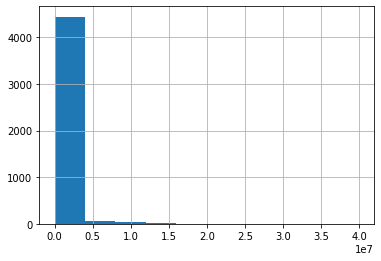

In [89]:
df_sku_tail_zero_count['tail_zero_count'].hist()

In [90]:
df_skus_overview

,sum,mean,median,std,skewness,kurtosis,coef_var,data_size,min_date,max_date,zero_percentage,zero_level,zero_count,tail_zero_count
SKU,,,,,,,,,,,,,,
country_10_material_1,1097760,5277.692308,5040.0,1436.515666,0.813211,1.390372,3.673954,208,2018-01-06,2021-12-25,0.0,0_25,0.0,40320
country_15_material_65,1109760,5335.384615,5040.0,2140.584111,0.712641,0.965166,2.492490,208,2018-01-06,2021-12-25,0.0,0_25,0.0,30000
country_15_material_64,610080,2933.076923,2880.0,1453.064113,0.675356,0.131583,2.018546,208,2018-01-06,2021-12-25,0.0,0_25,0.0,16800
country_29_material_65,125772480,604675.384615,575160.0,130514.936728,1.140732,1.750252,4.632998,208,2018-01-06,2021-12-25,0.0,0_25,0.0,5105280
country_42_material_2,69413040,333716.538462,312360.0,79783.320400,1.682913,4.085443,4.182786,208,2018-01-06,2021-12-25,0.0,0_25,0.0,3017760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
country_33_material_653,0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,59,2020-11-14,2021-12-25,1.0,75_100,59.0,0
country_7_material_357,0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,59,2020-11-14,2021-12-25,1.0,75_100,59.0,0
country_7_material_358,0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,59,2020-11-14,2021-12-25,1.0,75_100,59.0,0


c:\Users\ManuelSousa\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<AxesSubplot:title={'center':'sum'}>,
        <AxesSubplot:title={'center':'mean'}>,
        <AxesSubplot:title={'center':'median'}>],
       [<AxesSubplot:title={'center':'std'}>,
        <AxesSubplot:title={'center':'skewness'}>,
        <AxesSubplot:title={'center':'kurtosis'}>],
       [<AxesSubplot:title={'center':'coef_var'}>,
        <AxesSubplot:title={'center':'data_size'}>,
        <AxesSubplot:title={'center':'min_date'}>],
       [<AxesSubplot:title={'center':'max_date'}>,
        <AxesSubplot:title={'center':'zero_percentage'}>,
        <AxesSubplot:title={'center':'zero_count'}>]], dtype=object)

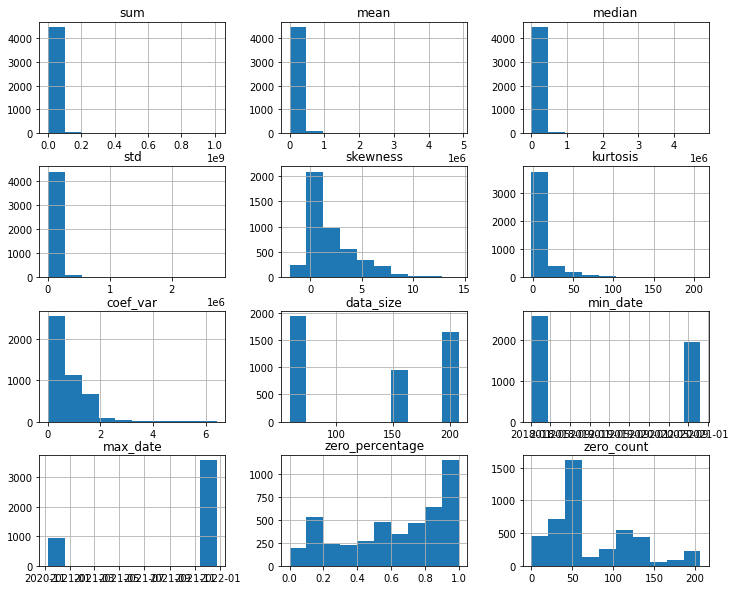

In [91]:
fig = plt.figure(figsize = (12,10))
ax = fig.gca()
df_skus_overview.hist(ax = ax)

In [92]:
df_skus_overview.describe()

,sum,mean,median,std,skewness,kurtosis,coef_var,data_size,zero_percentage,zero_count
count,4.545000e+03,4.545000e+03,4.545000e+03,4.545000e+03,4545.000000,4545.000000,4545.000000,4545.000000,4545.000000,4545.000000
mean,9.454796e+06,5.561664e+04,4.364738e+04,4.951597e+04,2.004337,10.602947,0.715321,131.767657,0.624728,74.141914
std,3.454269e+07,1.819497e+05,1.872340e+05,1.350976e+05,2.438408,22.136196,0.686118,66.550552,0.311574,49.511174
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.025697,-1.874139,0.000000,59.000000,0.000000,0.000000
25%,1.471200e+05,1.523758e+03,0.000000e+00,3.896342e+03,0.000000,0.000000,0.234036,59.000000,0.395973,41.000000
50%,1.027440e+06,8.282308e+03,0.000000e+00,1.413613e+04,1.210116,1.165314,0.534906,149.000000,0.694915,59.000000
75%,4.661760e+06,3.330692e+04,1.200000e+04,4.452842e+04,3.147472,10.921359,0.991194,208.000000,0.903846,107.000000
max,1.012388e+09,4.867248e+06,4.752960e+06,2.731271e+06,14.422205,208.000000,6.426456,208.000000,1.000000,207.000000


### Data Cleaning

In [93]:
df_skus_overview.shape[0]

4545

In [94]:
# remove if no complete data by date
df_skus_date_invalid = df_skus_overview.loc[df_skus_overview['max_date'] != '2021-12-25']
df_skus_overview = df_skus_overview.loc[df_skus_overview['max_date'] == '2021-12-25']
df_skus_overview.shape[0]

3587

In [95]:
# remove if data has only zeros
df_skus_only_zeros = df_skus_overview.loc[df_skus_overview['zero_percentage'] == 1]
df_skus_overview = df_skus_overview.loc[df_skus_overview['zero_percentage'] < 1]
df_skus_overview.shape[0]

2945

In [96]:
# remove if last X months are only zeros
df_skus_tail_zero_count = df_skus_overview.loc[df_skus_overview['tail_zero_count'] == 0]
df_skus_overview = df_skus_overview.loc[df_skus_overview['tail_zero_count'] > 0]
df_skus_overview.shape[0]

1998

In [97]:
# if it has zeros
# dfdf = df_skus_overview.copy()
# # df_skus_tail_zero_count_ = dfdf.loc[dfdf['zero_percentage'] == 0]
# dfdf = dfdf.loc[dfdf['zero_count'] < 20]
# dfdf.shape[0]

In [98]:
df_skus_overview

,sum,mean,median,std,skewness,kurtosis,coef_var,data_size,min_date,max_date,zero_percentage,zero_level,zero_count,tail_zero_count
SKU,,,,,,,,,,,,,,
country_10_material_1,1097760,5277.692308,5040.0,1436.515666,0.813211,1.390372,3.673954,208,2018-01-06,2021-12-25,0.000000,0_25,0.0,40320
country_15_material_65,1109760,5335.384615,5040.0,2140.584111,0.712641,0.965166,2.492490,208,2018-01-06,2021-12-25,0.000000,0_25,0.0,30000
country_15_material_64,610080,2933.076923,2880.0,1453.064113,0.675356,0.131583,2.018546,208,2018-01-06,2021-12-25,0.000000,0_25,0.0,16800
country_29_material_65,125772480,604675.384615,575160.0,130514.936728,1.140732,1.750252,4.632998,208,2018-01-06,2021-12-25,0.000000,0_25,0.0,5105280
country_42_material_2,69413040,333716.538462,312360.0,79783.320400,1.682913,4.085443,4.182786,208,2018-01-06,2021-12-25,0.000000,0_25,0.0,3017760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
country_12_material_532,23760,402.711864,0.0,3093.288525,7.681146,59.000000,0.130189,59,2020-11-14,2021-12-25,0.983051,75_100,58.0,23760
country_1_material_604,2400,40.677966,0.0,312.453386,7.681146,59.000000,0.130189,59,2020-11-14,2021-12-25,0.983051,75_100,58.0,2400
country_1_material_455,57600,976.271186,0.0,7498.881272,7.681146,59.000000,0.130189,59,2020-11-14,2021-12-25,0.983051,75_100,58.0,57600


In [99]:
df_skus_overview.describe()

,sum,mean,median,std,skewness,kurtosis,coef_var,data_size,zero_percentage,zero_count
count,1.998000e+03,1.998000e+03,1.998000e+03,1.998000e+03,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000
mean,1.204643e+07,7.197890e+04,4.185234e+04,6.173902e+04,1.823957,7.628461,0.963907,127.086587,0.506810,56.117618
std,4.045979e+07,2.031676e+05,1.706948e+05,1.422703e+05,1.954010,17.706239,0.770085,74.242015,0.285203,41.159882
min,2.400000e+02,4.067797e+00,0.000000e+00,3.124534e+01,-2.025697,-1.809142,0.085575,59.000000,0.000000,0.000000
25%,4.315800e+05,5.301356e+03,0.000000e+00,8.514748e+03,0.573742,-0.124609,0.439474,59.000000,0.186441,30.250000
50%,1.728000e+06,1.764870e+04,0.000000e+00,2.127694e+04,1.359269,1.935464,0.797375,59.000000,0.514423,47.000000
75%,7.073520e+06,5.218603e+04,1.962000e+04,5.816318e+04,2.606053,7.230060,1.170175,208.000000,0.745763,94.000000
max,1.012388e+09,4.867248e+06,4.752960e+06,2.172436e+06,13.381229,188.005538,6.426456,208.000000,0.990385,206.000000


In [100]:
invalid_frames = [df_skus_date_invalid, df_skus_only_zeros, df_skus_tail_zero_count]  
df_invalid_skus = pd.concat(invalid_frames)
df_invalid_skus.shape[0]

2547

## K-means Clustering

In [101]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.get_tracking_uri()
tracking_uri = mlflow.get_tracking_uri()
print("Current tracking uri: {}".format(tracking_uri))

Current tracking uri: http://127.0.0.1:5000


In [102]:
%run ./unsupervised

In [103]:
from sklearn.preprocessing import LabelEncoder

#create instance of label encoder
lab = LabelEncoder()

#perform label encoding on 'team' column
df_skus_overview['min_date'] = lab.fit_transform(df_skus_overview['min_date'])
df_skus_overview['max_date'] = lab.fit_transform(df_skus_overview['max_date'])
df_skus_overview['zero_level'] = lab.fit_transform(df_skus_overview['zero_level'])

In [104]:
#create scaled DataFrame where each variable has mean of 0 and standard dev of 1
scaled_df_skus_overview = StandardScaler().fit_transform(df_skus_overview)

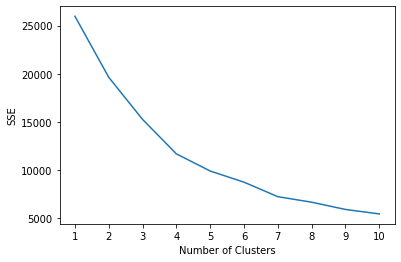

In [105]:
# Analyse K clusters quantity to choose
kmeans_analysis = Kmeans_Clustering()
sse = kmeans_analysis.cluster_sse(scaled_df_skus_overview)
kmeans_analysis.plot_sse(sse)

In [106]:
n_clusters, df_silhoutte_score = silhoutte_score_test(scaled_df_skus_overview, max_clusters=10)

In [107]:
df_silhoutte_score

,clusters,score
0,7,0.519473
0,9,0.511585
0,6,0.508512
0,8,0.501138
0,5,0.484051
0,4,0.466910
0,3,0.384329
0,2,0.356986


In [108]:
print("Best number of clusters:", n_clusters)

Best number of clusters: 7


In [109]:
mlflow.set_experiment(experiment_name='Clustering')
kmeans = Kmeans_Clustering(n_clusters=n_clusters)
kmeans_mlflow_registery = kmeans.train_with_mlflow_registry(scaled_df_skus_overview)
# kmeans.train(scaled_df_skus_overview)
kmeans_labels = kmeans.labels()

In [110]:
#append cluster assingments to original DataFrame
df_skus_overview['cluster'] = kmeans_labels

#view updated DataFrame
df_skus_overview

,sum,mean,median,std,skewness,kurtosis,coef_var,data_size,min_date,max_date,zero_percentage,zero_level,zero_count,tail_zero_count,cluster
SKU,,,,,,,,,,,,,,,
country_10_material_1,1097760,5277.692308,5040.0,1436.515666,0.813211,1.390372,3.673954,208,0,0,0.000000,0,0.0,40320,1
country_15_material_65,1109760,5335.384615,5040.0,2140.584111,0.712641,0.965166,2.492490,208,0,0,0.000000,0,0.0,30000,1
country_15_material_64,610080,2933.076923,2880.0,1453.064113,0.675356,0.131583,2.018546,208,0,0,0.000000,0,0.0,16800,1
country_29_material_65,125772480,604675.384615,575160.0,130514.936728,1.140732,1.750252,4.632998,208,0,0,0.000000,0,0.0,5105280,6
country_42_material_2,69413040,333716.538462,312360.0,79783.320400,1.682913,4.085443,4.182786,208,0,0,0.000000,0,0.0,3017760,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
country_12_material_532,23760,402.711864,0.0,3093.288525,7.681146,59.000000,0.130189,59,1,0,0.983051,3,58.0,23760,0
country_1_material_604,2400,40.677966,0.0,312.453386,7.681146,59.000000,0.130189,59,1,0,0.983051,3,58.0,2400,0
country_1_material_455,57600,976.271186,0.0,7498.881272,7.681146,59.000000,0.130189,59,1,0,0.983051,3,58.0,57600,0


In [111]:
df_skus_overview['cluster'].value_counts()

4    734
3    542
2    281
1    266
0    101
6     64
5     10
Name: cluster, dtype: int64

In [112]:
# Complete valid skus list
skus_list_clean = df_skus_overview.reset_index()['SKU'].unique()

In [113]:
len(skus_list_clean)

1998

In [114]:
df_cluster = {}
for cluster in range(0, n_clusters):
    cluster_name = 'cluster_' + str(cluster)
    df_skus_ov = df_skus_overview.loc[df_skus_overview['cluster'] == cluster]
    df_skus_ov = df_skus_ov.reset_index()    
    
    df_cluster[cluster_name] = {
        'sku_list': df_skus_ov['SKU'].unique(),      
        'data': df_global_clean.loc[df_skus_ov['SKU'].to_list()],
        'overview': df_skus_overview.loc[df_skus_overview['cluster'] == cluster]
    }

In [115]:
def plot_demand_per_date(df, title):
    dfplot = df[['Demand', 'Date']].copy()
    plt.figure(figsize=(15, 5))
    plt.scatter(dfplot['Date'], dfplot['Demand'])
    plt.title(title)

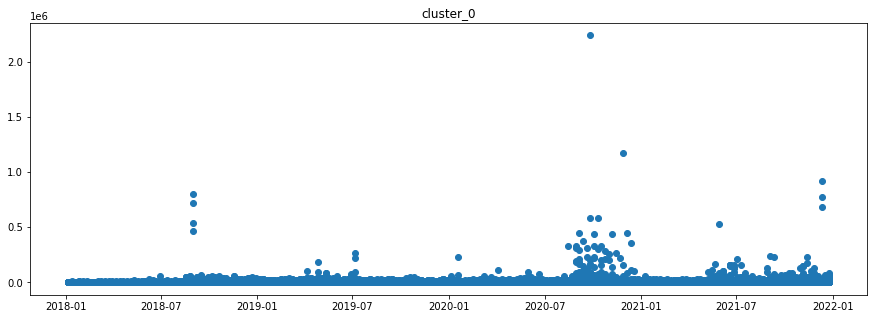

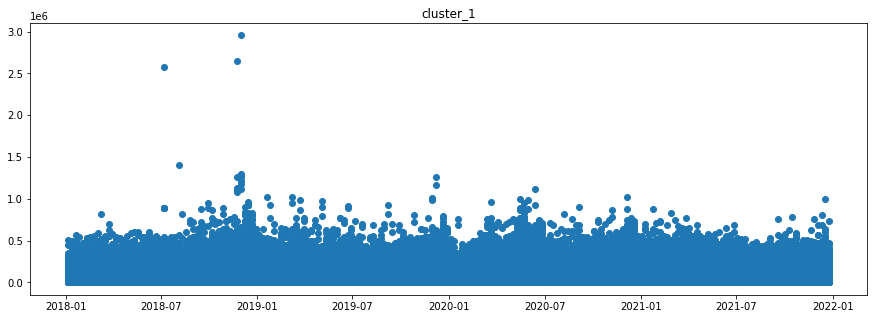

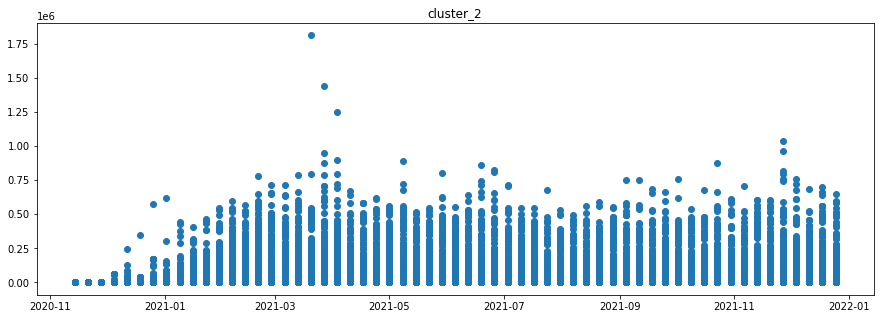

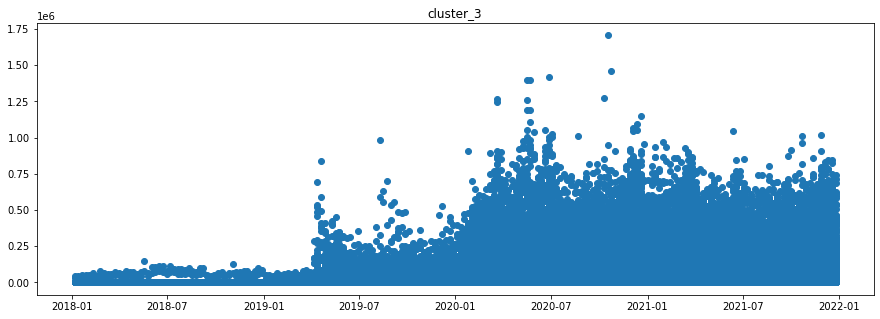

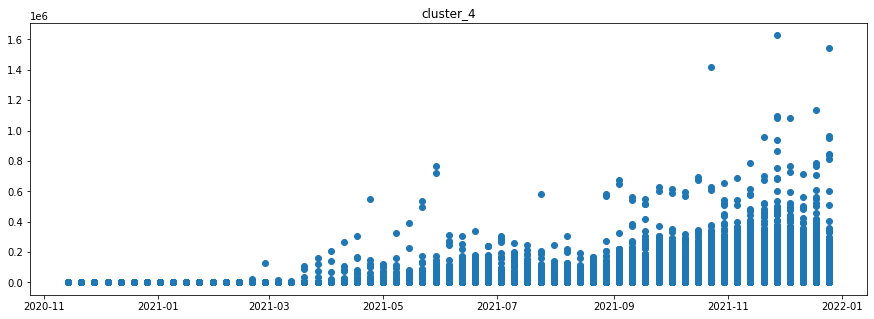

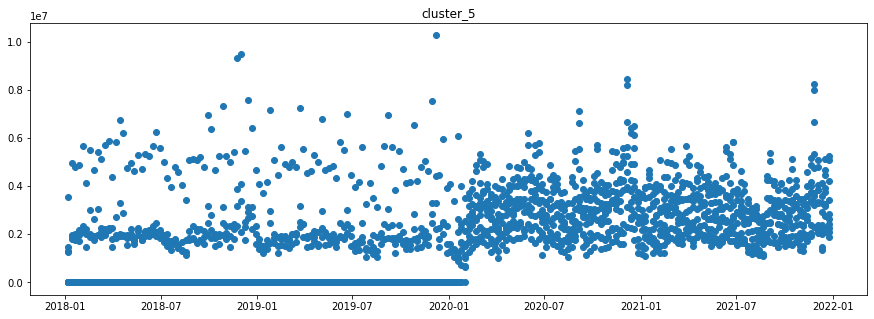

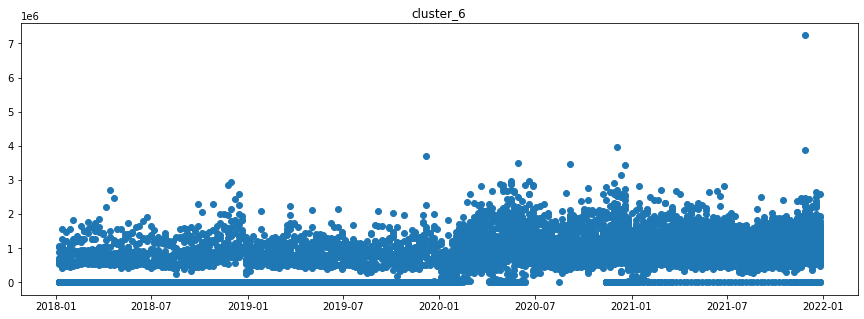

In [116]:
for cluster in range(0, n_clusters):
    cluster_name = 'cluster_' + str(cluster)
    data = df_cluster[cluster_name]['data']
    plot_demand_per_date(data, cluster_name)

## Model Training

In [117]:
experiment_name = "Nestle_" + str(n_clusters)  + "_clusters"
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='./artifacts/3', experiment_id='3', lifecycle_stage='active', name='Nestle_7_clusters', tags={}>

In [118]:
%run ./cluster_data
%run ./evaluation
%run ./supervised 

In [119]:
constant_cols = ["Zone", "Country_Code", "Material_Code", "year", "month", "week", "kurtosis", "skewness", "std", "mean", "coef_var"]  #, "covid"
dependent_cols = []  # ["mean", "std", "coef_var"]#, "kurtosis", "skewness"]
cols_to_drop = ["year","week", "month", "kurtosis", "skewness", "std", "mean", "coef_var"]
nr_lags = 8

config = {
    'id': None,
    'nr_lags': nr_lags,
    'target': 'Demand',
    'constant_cols': constant_cols,
    'dependent_cols': dependent_cols,
    'cols_to_drop': cols_to_drop,
    'constant_cols': constant_cols,
    'splitting_date': '2021-09-01',
    'train_date': '2020-10-01',
    'split_steps': 8,
    'threshold': 25
}    

In [120]:
str(kmeans_mlflow_registery.info.run_id)

'dcd33b37c4ef4055aeccce951903b1fc'

In [124]:
clusters_list = df_cluster.keys()
results = {}

for cluster in clusters_list:
    config['id'] = cluster
    print("\n#######################")
    print(cluster)

    ### BUILD DATASET

    cluster_x_data = Cluster_Data(cluster=df_cluster[cluster])

    # data split
    cluster_x_train, cluster_x_test  = cluster_x_data.train_test_step_split(split_steps=config['split_steps'])
    # cluster_x_train = cluster_x_train[cluster_x_train['Date'] >= config['train_date']]  

    # remove outliers from training dataset
    cluster_x_sku_list = cluster_x_data.get_sku_list()
    cluster_x_train = cluster_x_data.outliers_interpolation(cluster_x_train, cluster_x_sku_list, 2)  

    # seasonal and statistical features
    cluster_x_train = cluster_x_data.calculate_statistical_features(cluster_x_train)
    cluster_x_train = cluster_x_data.calculate_seasonal_features(cluster_x_train)
    cluster_x_test = cluster_x_data.calculate_seasonal_features(cluster_x_test)
    cluster_x_test = cluster_x_data.calculate_statistical_features_before_split(cluster_x_test)

    # train and test datasets with lags
    cluster_x_train_lags = cluster_x_data.training_features(
        cluster_x_train,
        constants=config['constant_cols'],
        dependents=config['dependent_cols'],
        to_drop=config['cols_to_drop'],
        lags=config['nr_lags']
    )

    cluster_x_test_lags = cluster_x_data.training_features(
        cluster_x_test,
        constants=config['constant_cols'],
        dependents=config['dependent_cols'],
        to_drop=config['cols_to_drop'],
        lags=config['nr_lags']
    )
    
    # Target/Input Features split
    X_train, y_train = cluster_x_data.target_features_split(cluster_x_train_lags, target=config['target'])
    X_test, y_test = cluster_x_data.target_features_split(cluster_x_test_lags, target=config['target'])

    # Standardize 
    # X_train_std, X_test_std = cluster_x_data.standardize(X_train, X_test)
    scaler = cluster_x_data.set_scaler(X_train)
    X_train_std = scaler.transform(X_train)
    X_test_std = scaler.transform(X_test)

    ### MODEL TRAINING
    print("Model Training...")

    # Random Forest
    cluster_x_rfr_model = Random_Forest()
    cluster_x_rfr_model.mlflow_pipeline(X_train_std, y_train, X_test_std, y_test, scaler=scaler, cluster_model_id=kmeans_mlflow_registery.info.run_id, sku_eval=cluster_x_test_lags, multistep_eval=df_cluster[cluster], run_name="RF_"+cluster)

    # XGBoost
    cluster_x_xgb_model = XGBoost()
    cluster_x_xgb_model.mlflow_pipeline(X_train_std, y_train, X_test_std, y_test, scaler=scaler, cluster_model_id=kmeans_mlflow_registery.info.run_id, sku_eval=cluster_x_test_lags, multistep_eval=df_cluster[cluster], run_name="XG_"+cluster)

    # Support Vector Regressor
    # cluster_x_svr_model = Support_Vector()
    # cluster_x_svr_model.mlflow_pipeline(X_train_std, y_train, X_test_std, y_test, scaler=scaler, cluster_model_id=kmeans_mlflow_registery.info.run_id, sku_eval=cluster_x_test_lags, multistep_eval=df_cluster[cluster], run_name="SV_"+cluster)

    ### EVALUATE
    # MAPE per SKU and Multistep forecasting per SKU

    cx_rfr_eval = cluster_x_rfr_model.eval_sku(cluster_x_test_lags, scaler, None)
    cx_rfr_ms_eval = cluster_x_rfr_model.multistep_eval_sku(df_cluster[cluster], scaler)
    # cx_rfr_client_forecast_eval = mape_sku_client_forecast('RF', cluster_x_test_lags, forecast_data, cluster_x_rfr_model.get_model(), scaler)

    cx_xgb_eval = cluster_x_xgb_model.eval_sku(cluster_x_test_lags, scaler, None)
    cx_xgb_ms_eval = cluster_x_xgb_model.multistep_eval_sku(df_cluster[cluster], scaler)
    # cx_xgb_client_forecast_eval = mape_sku_client_forecast('XG', cluster_x_test_lags, forecast_data, cluster_x_xgb_model.get_model(), scaler)
    
#     cx_svr_eval = cluster_x_svr_model.eval_sku(cluster_x_test_lags, scaler)
#     cx_svr_ms_eval = cluster_x_svr_model.multi_step_forecast(df_cluster[cluster], '_SV')

    print("Training Completed...")

    results[cluster] = {
        'rf': [cx_rfr_eval, cx_rfr_ms_eval],
        'xg': [cx_xgb_eval, cx_xgb_ms_eval]
#         'sv': [cx_svr_eval, cx_svr_ms_eval]
    }
    


#######################
cluster_0


c:\Users\ManuelSousa\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\Users\ManuelSousa\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\Users\ManuelSousa\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1773

Model Training...


c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_Forecast\experiment_3\supervised.py:94: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return df_multi_step_mape, df_multi_step_mape.mean(), df_multi_step_mape.median()
c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_Forecast\experiment_3\supervised.py:94: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return df_multi_step_mape, df_multi_step_mape.mean(), df_multi_step_mape.median()
c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_For

Training Completed...

#######################
cluster_1


c:\Users\ManuelSousa\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\Users\ManuelSousa\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\Users\ManuelSousa\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1773

Model Training...


c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_Forecast\experiment_3\supervised.py:94: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return df_multi_step_mape, df_multi_step_mape.mean(), df_multi_step_mape.median()
c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_Forecast\experiment_3\supervised.py:94: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return df_multi_step_mape, df_multi_step_mape.mean(), df_multi_step_mape.median()
c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_For

Training Completed...

#######################
cluster_2


c:\Users\ManuelSousa\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\Users\ManuelSousa\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\Users\ManuelSousa\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1773

Model Training...


c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_Forecast\experiment_3\supervised.py:94: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return df_multi_step_mape, df_multi_step_mape.mean(), df_multi_step_mape.median()
c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_Forecast\experiment_3\supervised.py:94: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return df_multi_step_mape, df_multi_step_mape.mean(), df_multi_step_mape.median()
c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_For

Training Completed...

#######################
cluster_3


c:\Users\ManuelSousa\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\Users\ManuelSousa\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\Users\ManuelSousa\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1773

Model Training...


c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_Forecast\experiment_3\supervised.py:94: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return df_multi_step_mape, df_multi_step_mape.mean(), df_multi_step_mape.median()
c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_Forecast\experiment_3\supervised.py:94: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return df_multi_step_mape, df_multi_step_mape.mean(), df_multi_step_mape.median()
c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_For

Training Completed...

#######################
cluster_4


c:\Users\ManuelSousa\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\Users\ManuelSousa\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\Users\ManuelSousa\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1773

Model Training...


c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_Forecast\experiment_3\supervised.py:94: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return df_multi_step_mape, df_multi_step_mape.mean(), df_multi_step_mape.median()
c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_Forecast\experiment_3\supervised.py:94: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return df_multi_step_mape, df_multi_step_mape.mean(), df_multi_step_mape.median()
c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_For

Training Completed...

#######################
cluster_5


c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_Forecast\experiment_3\cluster_data.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['mean'] = df_calc.groupby(['SKU']).mean()
c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_Forecast\experiment_3\cluster_data.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['std'] = df_calc.groupby(['SKU']).std()
c:\Users\ManuelSou

Model Training...


c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_Forecast\experiment_3\supervised.py:94: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return df_multi_step_mape, df_multi_step_mape.mean(), df_multi_step_mape.median()
c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_Forecast\experiment_3\supervised.py:94: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return df_multi_step_mape, df_multi_step_mape.mean(), df_multi_step_mape.median()
c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_For

Training Completed...

#######################
cluster_6


c:\Users\ManuelSousa\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\Users\ManuelSousa\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\Users\ManuelSousa\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1773

Model Training...


c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_Forecast\experiment_3\supervised.py:94: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return df_multi_step_mape, df_multi_step_mape.mean(), df_multi_step_mape.median()
c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_Forecast\experiment_3\supervised.py:94: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return df_multi_step_mape, df_multi_step_mape.mean(), df_multi_step_mape.median()
c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_For

Training Completed...


c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_Forecast\experiment_3\supervised.py:94: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return df_multi_step_mape, df_multi_step_mape.mean(), df_multi_step_mape.median()
c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_Forecast\experiment_3\supervised.py:94: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return df_multi_step_mape, df_multi_step_mape.mean(), df_multi_step_mape.median()


In [145]:
results['cluster_0']['rf'][0][0].sort_values(by='Material_Code')

,Country_Code,Material_Code,MAPE_RF
1,8,1,64.47
4,8,2,69.91
24,8,8,33.64
11,27,10,100.00
16,8,10,100.00
...,...,...,...
91,40,621,28285.22
77,9,622,100.00
39,41,624,100.00
94,20,694,100.00


In [125]:
for i in clusters_list:    
    cl = results[i]
    print("###########################")
    print(i)
    print("Random Forest")
    print("Média", cl['rf'][1][1], "Mediana", cl['rf'][1][2])
    # print("For: Média", cl['rf'][2][1], "Mediana", cl['rf'][2][2])
    print("XGBoost")
    print("Média", cl['xg'][1][1], "Mediana", cl['xg'][1][2])
    # print("For: Média", cl['xg'][2][1], "Mediana", cl['xg'][2][2])
    print()

###########################
cluster_0
Random Forest
Média 8 step MAPE RF    1.340693e+21
dtype: float64 Mediana 8 step MAPE RF    1.646339e+21
dtype: float64
XGBoost
Média 8 step MAPE XB    9.990993e+20
dtype: float64 Mediana 8 step MAPE XB    7.046657e+20
dtype: float64

###########################
cluster_1
Random Forest
Média 8 step MAPE RF    4.336157e+21
dtype: float64 Mediana 8 step MAPE RF    44.73
dtype: float64
XGBoost
Média 8 step MAPE XB    4.261809e+21
dtype: float64 Mediana 8 step MAPE XB    33.295
dtype: float64

###########################
cluster_2
Random Forest
Média 8 step MAPE RF    3.105223e+20
dtype: float64 Mediana 8 step MAPE RF    29.01
dtype: float64
XGBoost
Média 8 step MAPE XB    2.797179e+20
dtype: float64 Mediana 8 step MAPE XB    29.87
dtype: float64

###########################
cluster_3
Random Forest
Média 8 step MAPE RF    2.393141e+21
dtype: float64 Mediana 8 step MAPE RF    31.28
dtype: float64
XGBoost
Média 8 step MAPE XB    1.761588e+21
dtype: float

Worst trained cluster is considered an outlier. The remaining cliusters are merged and trained as a universal model. To assess which cluster is the worst de random forest model MAPE is used.

In [126]:
# Find worst cluster
worst_cluster_mape = 0
for c in clusters_list:
    print(results[c]['rf'][0][1]) 
    rf_mape_result = results[c]['rf'][0][1]
    if rf_mape_result > worst_cluster_mape:
        worst_cluster_mape = rf_mape_result
        worst_cluster = c

print("Worst cluster:")
print(worst_cluster_mape, worst_cluster)

1661.0471287128707
167.9912781954887
31.02857651245552
45.95485239852398
50.57019073569483
17.445999999999998
24.515
Worst cluster:
1661.0471287128707 cluster_0


In [130]:
# Merge best clusters info and data, as one
best_clusters = {}
best_sku_list = []
best_sku_data = pd.DataFrame()
best_sku_overview = pd.DataFrame()

for cluster in clusters_list:
    if cluster != worst_cluster:
        best_sku_list = np.concatenate((best_sku_list, df_cluster[cluster]['sku_list']), axis=0)
        best_sku_data = best_sku_data.append(df_cluster[cluster]['data'])
        best_sku_overview = best_sku_overview.append(df_cluster[cluster]['overview'])

best_clusters = {
    'sku_list': best_sku_list,
    'data': best_sku_data,
    'overview': best_sku_overview
}

Best clusters merged training

In [131]:
experiment_name = "Nestle_global_best_clusters"
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='./artifacts/4', experiment_id='4', lifecycle_stage='active', name='Nestle_global_best_clusters', tags={}>

In [146]:
print("\n#######################")
print("UNIVERSAL MODEL - BEST CLUSTERS")

### BUILD DATASET

bclusters_data = Cluster_Data(cluster=best_clusters)

# data split
bclusters_train, bclusters_test  = bclusters_data.train_test_step_split(split_steps=config['split_steps'])
# bclusters_train = bclusters_train[bclusters_train['Date'] >= config['train_date']]  

# remove outliers from training dataset
bclusters_sku_list = bclusters_data.get_sku_list()
bclusters_train = bclusters_data.outliers_interpolation(bclusters_train, bclusters_sku_list, 2)  

# seasonal and statistical features
bclusters_train = bclusters_data.calculate_statistical_features(bclusters_train)
bclusters_train = bclusters_data.calculate_seasonal_features(bclusters_train)
bclusters_test = bclusters_data.calculate_seasonal_features(bclusters_test)
bclusters_test = bclusters_data.calculate_statistical_features_before_split(bclusters_test)

# train and test datasets with lags
bclusters_train_lags = bclusters_data.training_features(
    bclusters_train,
    constants=config['constant_cols'],
    dependents=config['dependent_cols'],
    to_drop=config['cols_to_drop'],
    lags=config['nr_lags']
)

bclusters_test_lags = bclusters_data.training_features(
    bclusters_test,
    constants=config['constant_cols'],
    dependents=config['dependent_cols'],
    to_drop=config['cols_to_drop'],
    lags=config['nr_lags']
)

# Target/Input Features split
bc_X_train, bc_y_train = bclusters_data.target_features_split(bclusters_train_lags, target=config['target'])
bc_X_test, bc_y_test = bclusters_data.target_features_split(bclusters_test_lags, target=config['target'])

# Standardize 
# bc_X_train_std, bc_X_test_std = bclusters_data.standardize(bc_X_train, bc_X_test)
bc_scaler = bclusters_data.set_scaler(bc_X_train)
bc_X_train_std = bc_scaler.transform(bc_X_train)
bc_X_test_std = bc_scaler.transform(bc_X_test)

### MODEL TRAINING
print("Model Training...")

# Random Forest
bclusters_rfr_model = Random_Forest()
bclusters_rfr_model.mlflow_pipeline(bc_X_train_std, bc_y_train, bc_X_test_std, bc_y_test, scaler=bc_scaler, cluster_model_id=kmeans_mlflow_registery.info.run_id, sku_eval=bclusters_test_lags, multistep_eval=df_cluster[cluster], run_name="RF_"+cluster)

# XGBoost
bclusters_xgb_model = XGBoost()
bclusters_xgb_model.mlflow_pipeline(bc_X_train_std, bc_y_train, bc_X_test_std, bc_y_test, scaler=bc_scaler, cluster_model_id=kmeans_mlflow_registery.info.run_id, sku_eval=bclusters_test_lags, multistep_eval=df_cluster[cluster], run_name="XG_"+cluster)

# Support Vector Regressor
# cluster_x_svr_model = Support_Vector()
# cluster_x_svr_model.mlflow_pipeline(bc_X_train_std, bc_y_train, bc_X_test_std, bc_y_test, scaler=bc_scaler, cluster_model_id=kmeans_mlflow_registery.info.run_id, sku_eval=cluster_x_test_lags, multistep_eval=df_cluster[cluster], run_name="SV_"+cluster)

### EVALUATE
# MAPE per SKU and Multistep forecasting per SKU

bc_rfr_eval = bclusters_rfr_model.eval_sku(bclusters_test_lags, bc_scaler, None)
bc_rfr_ms_eval = bclusters_rfr_model.multistep_eval_sku(best_clusters, bc_scaler)
# bc_rfr_client_forecast_eval = mape_sku_client_forecast('RF', bclusters_test_lags, forecast_data, bclusters_rfr_model.get_model(), scaler)

bc_xgb_eval = bclusters_xgb_model.eval_sku(bclusters_test_lags, bc_scaler, None)
bc_xgb_ms_eval = bclusters_xgb_model.multistep_eval_sku(best_clusters, bc_scaler)
# bc_xgb_client_forecast_eval = mape_sku_client_forecast('XG', bclusters_test_lags, forecast_data, bclusters_xgb_model.get_model(), scaler)

#     bc_svr_eval = bclusters_svr_model.eval_sku(bclusters_test_lags, scaler)
#     bc_svr_ms_eval = bclusters_svr_model.multi_step_forecast(df_cluster[cluster], '_SV')

print("Training Completed...")

best_clusters_results = {
    'rf': [bc_rfr_eval, bc_rfr_ms_eval],
    'xg': [bc_xgb_eval, bc_xgb_ms_eval]
#         'sv': [bc_svr_eval, bc_svr_ms_eval]
}


#######################
UNIVERSAL MODEL - BEST CLUSTERS


c:\Users\ManuelSousa\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\Users\ManuelSousa\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\Users\ManuelSousa\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1773

Model Training...


c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_Forecast\experiment_3\supervised.py:94: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return df_multi_step_mape, df_multi_step_mape.mean(), df_multi_step_mape.median()
c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_Forecast\experiment_3\supervised.py:94: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return df_multi_step_mape, df_multi_step_mape.mean(), df_multi_step_mape.median()
c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_For

Training Completed...


c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_Forecast\experiment_3\supervised.py:94: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return df_multi_step_mape, df_multi_step_mape.mean(), df_multi_step_mape.median()
c:\Users\ManuelSousa\Documents\Pós-Graduação Applied AI & ML\Bloco 3\AI & ML Project\ML_Stock_Keeping_Unit_Forecast\experiment_3\supervised.py:94: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return df_multi_step_mape, df_multi_step_mape.mean(), df_multi_step_mape.median()


In [147]:
print(best_clusters_results['rf'][0][1], best_clusters_results['rf'][0][2])
print(best_clusters_results['rf'][1][1], best_clusters_results['rf'][1][2])
print(best_clusters_results['xg'][0][1], best_clusters_results['xg'][0][2])
print(best_clusters_results['xg'][1][1], best_clusters_results['xg'][1][2])

50.896225619399054 31.44
8 step MAPE RF    2.685626e+21
dtype: float64 8 step MAPE RF    45.03
dtype: float64
71.69472851871376 33.25
8 step MAPE XB    1.995237e+21
dtype: float64 8 step MAPE XB    40.44
dtype: float64


In [169]:
best_clusters_results['rf'][1][0][best_clusters_results['rf'][1][0]['SKU'].str.endswith('material_1')] 

,SKU,8 step MAPE RF
592,country_27_material_1,2.350000e+01
650,country_5_material_1,2.527000e+01
651,country_6_material_1,2.531000e+01
687,country_42_material_1,2.639000e+01
1204,country_10_material_1,2.256600e+02
1709,country_1_material_1,8.813562e+21


In [148]:
best_clusters_results['xg'][0][0]['MAPE_XB'].describe()

count     1897.000000
mean        71.694729
std        470.133081
min          0.000000
25%         15.580000
50%         33.250000
75%         75.440000
max      13492.750000
Name: MAPE_XB, dtype: float64